In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [133]:
ticker = 'JBFCF'
df = yf.download(ticker, '2020-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [134]:
df

Price,Close,High,Low,Open,Volume
Ticker,JBFCF,JBFCF,JBFCF,JBFCF,JBFCF
Date,,,,,
2020-01-02,4.028040,4.122817,4.028040,4.122817,3300
2020-01-03,3.999605,4.028039,3.990128,4.028039,2800
2020-01-06,4.028040,4.056473,3.933263,3.933263,1600
2020-01-07,4.018561,4.018561,4.009084,4.009084,1000
2020-01-08,3.990129,4.046995,3.980651,4.046995,2500
...,...,...,...,...,...
2025-10-13,4.000000,4.000000,4.000000,4.000000,700
2025-10-14,4.010000,4.010000,3.880000,4.010000,2100


<Axes: xlabel='Date'>

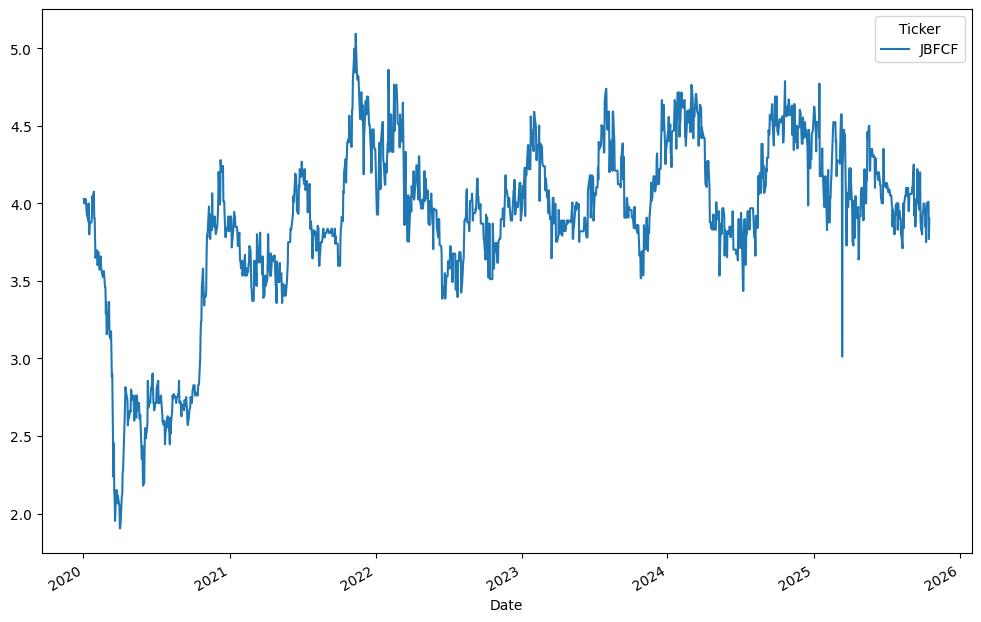

In [135]:
df.Close.plot(figsize=(12, 8))

In [136]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [137]:
df.Close

Ticker,JBFCF
Date,
2020-01-02,0.255861
2020-01-03,0.204058
2020-01-06,0.255861
2020-01-07,0.238593
2020-01-08,0.186793
...,...
2025-10-13,0.204777
2025-10-14,0.222996
2025-10-15,0.222996


In [138]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [139]:
data

array([[[ 0.25586122],
        [ 0.20405788],
        [ 0.25586122],
        ...,
        [-0.57295627],
        [-0.50388833],
        [-0.41755361]],

       [[ 0.20405788],
        [ 0.25586122],
        [ 0.23859272],
        ...,
        [-0.50388833],
        [-0.41755361],
        [-0.53842143]],

       [[ 0.25586122],
        [ 0.23859272],
        [ 0.18679284],
        ...,
        [-0.41755361],
        [-0.53842143],
        [-0.65929055]],

       ...,

       [[ 0.31408748],
        [ 0.38696131],
        [ 0.38696131],
        ...,
        [ 0.20477675],
        [ 0.20477675],
        [ 0.22299564]],

       [[ 0.38696131],
        [ 0.38696131],
        [ 0.66023859],
        ...,
        [ 0.20477675],
        [ 0.22299564],
        [ 0.22299564]],

       [[ 0.38696131],
        [ 0.66023859],
        [ 0.05902909],
        ...,
        [ 0.22299564],
        [ 0.22299564],
        [-0.21424818]]])

In [140]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [141]:
Y_train

tensor([[-0.4176],
        [-0.5384],
        [-0.6593],
        ...,
        [ 0.3270],
        [ 0.9025],
        [ 0.9025]])

In [142]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)    

        out, (hn, cn) = self.lstm(x,(h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [143]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [144]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [145]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, Y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 1.1128793954849243
25 0.08249728381633759
50 0.050557877868413925
75 0.04597949981689453
100 0.04375928267836571
125 0.04227679595351219
150 0.041655201464891434
175 0.04160527139902115


In [146]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
Y_train = scaler.inverse_transform(Y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
Y_test = scaler.inverse_transform(Y_test.detach().cpu().numpy())

In [147]:
train_rmse = root_mean_squared_error(Y_train[:, 0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(Y_test[:, 0], y_test_pred[:,0])

In [148]:
train_rmse

0.11165867000818253

In [149]:
test_rmse

0.16295361518859863

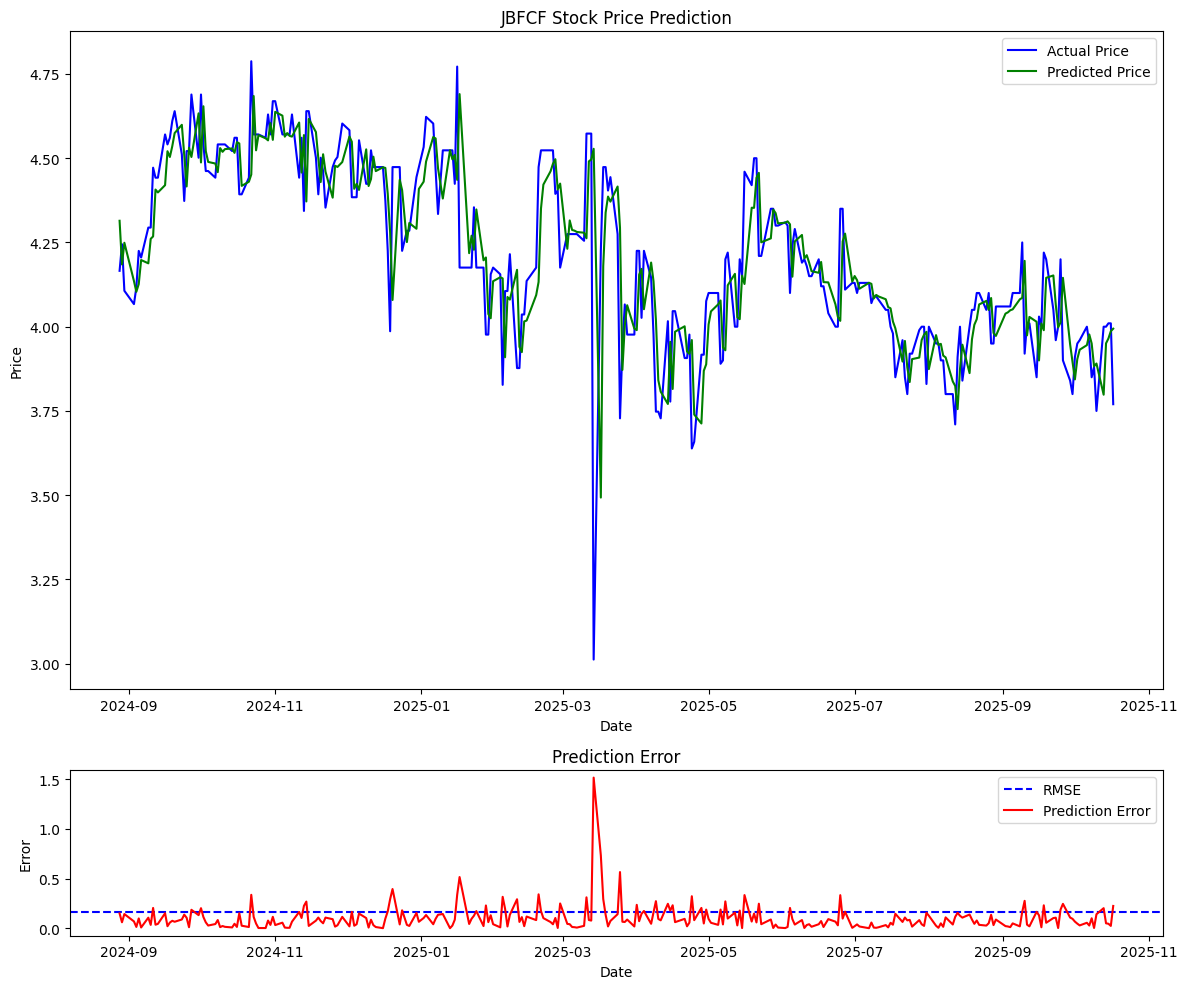

In [152]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(Y_test):].index, Y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(Y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle= '--', label = 'RMSE')
ax2.plot(df[-len(Y_test):].index, abs(Y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
    
plt.tight_layout()
plt.savefig("jfc_stock_prediction.png", dpi=300, bbox_inches='tight')
plt.show()
         

In [151]:
print("Sample actual prices:", Y_test[:5].flatten())
print("Sample predicted prices:", y_test_pred[:5].flatten())


Sample actual prices: [4.1658063 4.2447796 4.1065774 4.0670905 4.116449 ]
Sample predicted prices: [4.3143363 4.1849103 4.24915   4.1355386 4.10363  ]
